# S&P 500 Performance Analysis: Democratic vs Republican Presidencies

This notebook analyzes the performance of the S&P 500 under different presidential administrations from 1993 to present. We'll examine:

1. Returns and volatility under different parties
2. Statistical significance of performance differences
3. Bull and bear market patterns
4. Risk-adjusted performance metrics

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from scipy import stats
import scipy.stats as st




# Set visualization styles
plt.style.use('default')  # Changed from 'seaborn'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True  # Add grid by default
plt.rcParams['grid.alpha'] = 0.3  # Lighter grid lines

print('All imports successful!')



All imports successful!


## 1. Data Loading and Cleaning

First, we'll define functions to load and clean the S&P 500 data:

In [67]:
def clean_sp500_data(df):
    """Clean and prepare S&P 500 data for analysis."""
    df = df.copy()
    
    # Convert date
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Clean numeric columns
    numeric_cols = ['Price', 'Open', 'High', 'Low']
    for col in numeric_cols:
        df[col] = df[col].str.replace(',', '').astype(float)
    
    # Clean percentage column
    df['Change %'] = df['Change %'].str.replace('%', '').astype(float) / 100
    
    # Sort by date and reset index
    df = df.sort_values('Date').reset_index(drop=True)
    
    return df

# Load and clean data
sp500_data = pd.read_csv('S&P 500 Historical Data monthly(1970-2025).csv')
sp500_clean = clean_sp500_data(sp500_data)


# Display the first few rows
print("First few rows of cleaned data:")
sp500_clean.head()

First few rows of cleaned data:


,Date,Price,Open,High,Low,Vol.,Change %
0,1970-02-01,89.5,89.5,89.5,89.5,NaN,0.0529
1,1970-03-01,89.6,89.6,89.6,89.6,NaN,0.0011
2,1970-04-01,81.5,81.5,81.5,81.5,NaN,-0.0904
3,1970-05-01,76.5,76.5,76.5,76.5,NaN,-0.0613
4,1970-06-01,72.7,72.7,72.7,72.7,NaN,-0.0497


## 2. Adding Presidential Information

Now we'll add information about presidential terms and parties to our dataset:

In [69]:
def add_presidential_data(df):
    """Add presidential party information to the dataset."""
    presidents = {
        'Nixon': {'start': '1969-01-20', 'end': '1974-08-09', 'party': 'Republican'},
        'Ford': {'start': '1974-08-09', 'end': '1977-01-20', 'party': 'Republican'},
        'Carter': {'start': '1977-01-20', 'end': '1981-01-20', 'party': 'Democratic'},
        'Reagan': {'start': '1981-01-20', 'end': '1989-01-20', 'party': 'Republican'},
        'Bush Sr': {'start': '1989-01-20', 'end': '1993-01-20', 'party': 'Republican'},
        'Clinton': {'start': '1993-01-20', 'end': '2001-01-20', 'party': 'Democratic'},
        'Bush Jr': {'start': '2001-01-20', 'end': '2009-01-20', 'party': 'Republican'},
        'Obama': {'start': '2009-01-20', 'end': '2017-01-20', 'party': 'Democratic'},
        'Trump': {'start': '2017-01-20', 'end': '2021-01-20', 'party': 'Republican'},
        'Biden': {'start': '2021-01-20', 'end': '2025-01-20', 'party': 'Democratic'},
        'Trump ':  {'start': '2025-01-20', 'end': '2029-01-20', 'party': 'Republican'}
    }
    
    df = df.copy()
    df['President'] = ''
    df['Party'] = ''
    
    for president, info in presidents.items():
        mask = (df['Date'] >= pd.to_datetime(info['start'])) & \
               (df['Date'] < pd.to_datetime(info['end']))
        df.loc[mask, 'President'] = president
        df.loc[mask, 'Party'] = info['party']
    
    # Add binary indicator for Democratic (1) vs Republican (0)
    df['is_Democratic'] = (df['Party'] == 'Democratic').astype(int)
    
    return df

# Add presidential data
sp500_with_presidents = add_presidential_data(sp500_clean)

#Add Era Column
def categorize_era(row):
    if row['Date'] < pd.Timestamp('2000-01-01'):
        return 'Pre-2000s'
    else:
        return 'Post-2000s'

sp500_with_presidents['Era'] = sp500_with_presidents.apply(categorize_era, axis=1)

# Display distribution of data points by party
party_distribution = sp500_with_presidents['Party'].value_counts()
print("\nNumber of trading months by party:")
print(party_distribution)

# Display sample of data with presidential information
print("\nSample of data with presidential information:")
sp500_with_presidents[['Date', 'Price', 'President', 'Party']].head(30)
sp500_with_presidents.head(30)


Number of trading months by party:
Party
Republican    376
Democratic    288
Name: count, dtype: int64

Sample of data with presidential information:


,Date,Price,Open,High,Low,Vol.,Change %,President,Party,is_Democratic,Era
0,1970-02-01,89.5,89.5,89.5,89.5,NaN,0.0529,Nixon,Republican,0,Pre-2000s
1,1970-03-01,89.6,89.6,89.6,89.6,NaN,0.0011,Nixon,Republican,0,Pre-2000s
2,1970-04-01,81.5,81.5,81.5,81.5,NaN,-0.0904,Nixon,Republican,0,Pre-2000s
3,1970-05-01,76.5,76.5,76.5,76.5,NaN,-0.0613,Nixon,Republican,0,Pre-2000s
4,1970-06-01,72.7,72.7,72.7,72.7,NaN,-0.0497,Nixon,Republican,0,Pre-2000s
5,1970-07-01,78.0,78.0,78.0,78.0,NaN,0.0729,Nixon,Republican,0,Pre-2000s
6,1970-08-01,81.5,81.5,81.5,81.5,NaN,0.0449,Nixon,Republican,0,Pre-2000s
7,1970-09-01,84.2,84.2,84.2,84.2,NaN,0.0331,Nixon,Republican,0,Pre-2000s
8,1970-10-01,83.2,83.2,83.2,83.2,NaN,-0.0119,Nixon,Republican,0,Pre-2000s
9,1970-11-01,87.2,87.2,87.2,87.2,NaN,0.0481,Nixon,Republican,0,Pre-2000s


## 3. Calculating Returns

Let's calculate various return metrics including monthly returns, log returns, and cumulative returns:

Summary statistics of Monthly returns:
count    663.0000
mean       0.0073
std        0.0441
min       -0.2175
25%       -0.0179
50%        0.0102
75%        0.0358
max        0.1638
Name: Monthly_Return, dtype: float64


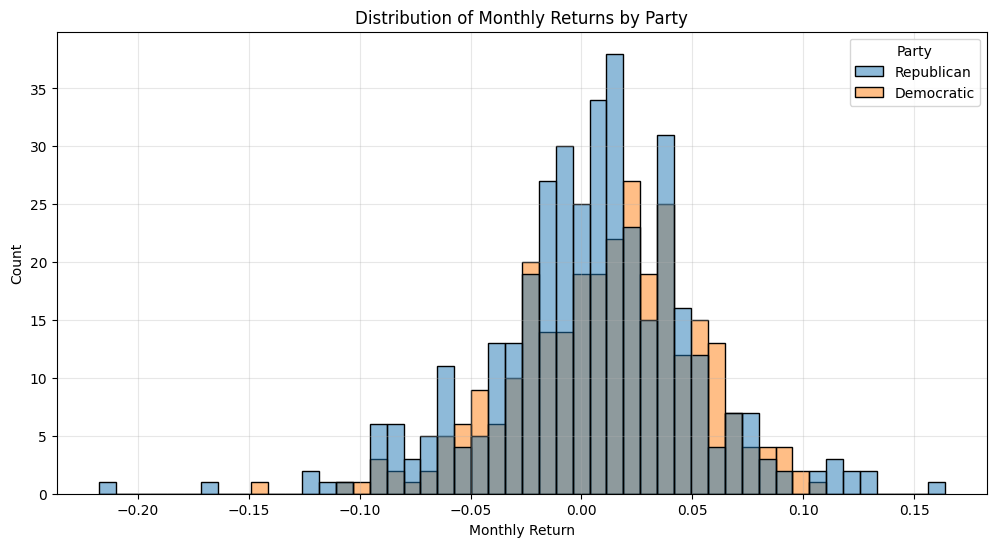

In [70]:
def calculate_returns(df):
    """Calculate various return metrics."""
    df = df.copy()
    
    # Calculate returns
    df['Monthly_Return'] = df['Price'].pct_change()
    df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
    df['Cumulative_Return'] = (1 + df['Monthly_Return']).cumprod() - 1
    
    # Calculate rolling metrics
    df['Rolling_Vol_30d'] = df['Monthly_Return'].rolling(window=30).std() * np.sqrt(252)
    df['Rolling_Return_30d'] = df['Monthly_Return'].rolling(window=30).mean() * 252
    
    return df

# Calculate returns
sp500_with_returns = calculate_returns(sp500_with_presidents)

# Display summary statistics of returns
print("Summary statistics of Monthly returns:")
print(sp500_with_returns['Monthly_Return'].describe().round(4))

# Plot monthly returns distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=sp500_with_returns, x='Monthly_Return', hue='Party', bins=50, alpha=0.5)
plt.title('Distribution of Monthly Returns by Party')
plt.xlabel('Monthly Return')
plt.ylabel('Count')
plt.show()

## 4. Performance Analysis

Now let's analyze the performance metrics for each party and create visualizations:

Performance Metrics by Party:
Party                                
Democratic  Monthly Return (%)             1.09
            Monthly Volatility (%)         4.10
            Annualized Return (%)        274.19
            Annualized Volatility (%)     65.15
            Sharpe Ratio                   4.21
            Positive Days (%)             64.24
            Maximum Drawdown (%)         346.90
Republican  Monthly Return (%)             0.45
            Monthly Volatility (%)         4.61
            Annualized Return (%)        112.59
            Annualized Volatility (%)     73.20
            Sharpe Ratio                   1.54
            Positive Days (%)             57.18
            Maximum Drawdown (%)         204.37
Name: Monthly_Return, dtype: float64


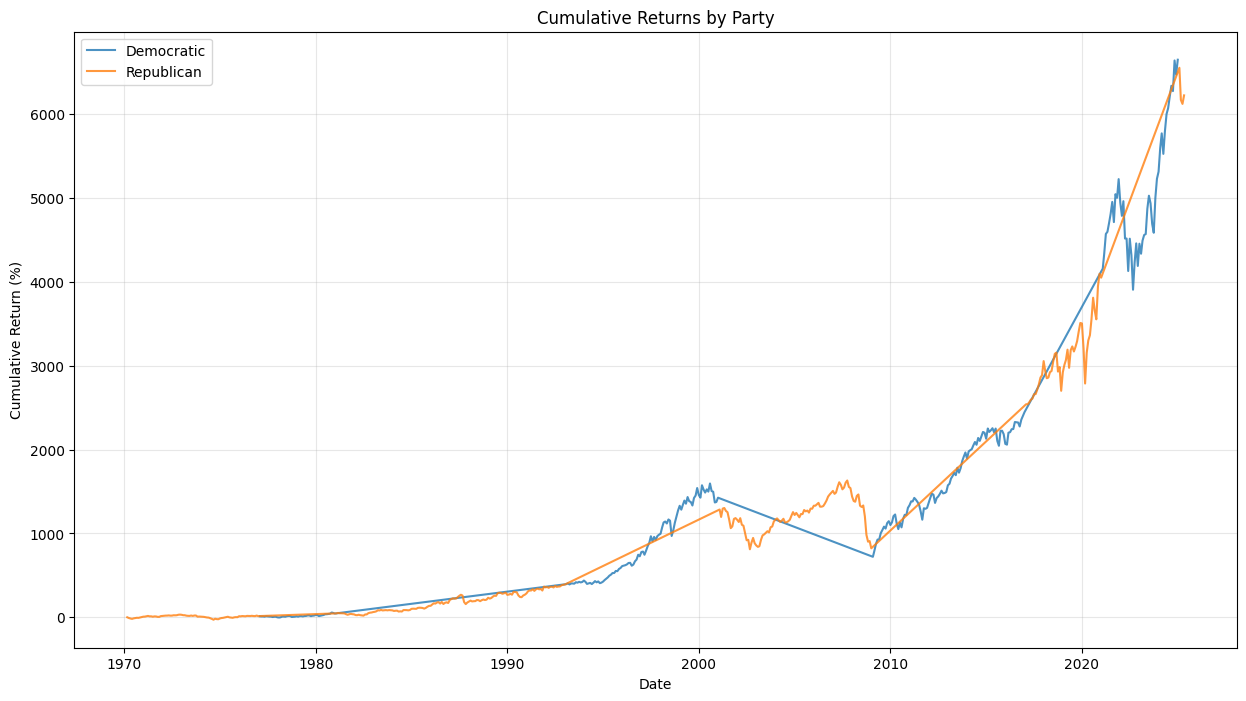

In [71]:
def calculate_performance_metrics(returns):
    """Calculate key performance metrics for a return series."""
    metrics = {
        'Monthly Return (%)': returns.mean() * 100,
        'Monthly Volatility (%)': returns.std() * 100,
        'Annualized Return (%)': returns.mean() * 252 * 100,
        'Annualized Volatility (%)': returns.std() * np.sqrt(252) * 100,
        'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
        'Positive Days (%)': (returns > 0).mean() * 100,
        'Maximum Drawdown (%)': ((1 + returns).cumprod().expanding().max() - 
                                (1 + returns).cumprod()).max() * 100
    }
    return pd.Series(metrics)

# Calculate metrics by party
party_metrics = sp500_with_returns.groupby('Party')['Monthly_Return'].apply(calculate_performance_metrics)
print("Performance Metrics by Party:")
print(party_metrics.round(2))

# Plot cumulative returns
plt.figure(figsize=(15, 8))
for party in ['Democratic', 'Republican']:
    party_data = sp500_with_returns[sp500_with_returns['Party'] == party]
    plt.plot(party_data['Date'], party_data['Cumulative_Return'] * 100, 
             label=party, alpha=0.8)

plt.title('Cumulative Returns by Party')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Statistical Analysis

Let's perform statistical tests to determine if there are significant differences in returns between parties:

In [72]:
# Cell 6: Statistical Tests
# Copy everything below this line into your sixth code cell
#-----------------------------------------------------------
# Clean and prepare return data for statistical analysis
dem_returns = sp500_with_returns[sp500_with_returns['Party'] == 'Democratic']['Monthly_Return'].dropna()
rep_returns = sp500_with_returns[sp500_with_returns['Party'] == 'Republican']['Monthly_Return'].dropna()

# Perform t-test on cleaned data
t_stat, p_value = stats.ttest_ind(dem_returns, rep_returns, equal_var=False, nan_policy='omit')

print("Statistical Test Results:")
print(f"Number of Democratic months: {len(dem_returns)}")
print(f"Number of Republican months: {len(rep_returns)}")
print(f"\nDemocratic mean monthly return: {dem_returns.mean()*100:.4f}%")
print(f"Republican mean monthly return: {rep_returns.mean()*100:.4f}%")
print(f"Difference: {(dem_returns.mean() - rep_returns.mean())*100:.4f}%")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"\nInterpretation: {'Statistically significant' if p_value < 0.05 else 'Not statistically significant'} at 5% level")

# Regression analysis with cleaned data
# First, create a clean dataset for regression
regression_data = sp500_with_returns[['Monthly_Return', 'is_Democratic']].dropna()
X = sm.add_constant(regression_data['is_Democratic'])
y = regression_data['Monthly_Return']

# Perform regression
model = sm.OLS(y, X).fit()

print("\nRegression Analysis:")
print("====================")
print(f"R-squared: {model.rsquared:.4f}")
print("\nCoefficients:")
print("-------------")
print(f"Intercept (Republican): {model.params[0]*100:.4f}%")
print(f"Democratic Premium: {model.params[1]*100:.4f}%")
print("\nP-values:")
print("-------------")
print(f"Intercept: {model.pvalues[0]:.4f}")
print(f"Democratic Premium: {model.pvalues[1]:.4f}")

# Additional statistics
print("\nAdditional Statistics:")
print("---------------------")
print(f"Democratic Volatility: {dem_returns.std()*100:.4f}%")
print(f"Republican Volatility: {rep_returns.std()*100:.4f}%")

00

Statistical Test Results:
Number of Democratic months: 288
Number of Republican months: 375

Democratic mean monthly return: 1.0880%
Republican mean monthly return: 0.4468%
Difference: 0.6413%
t-statistic: 1.8893
p-value: 0.0593

Interpretation: Not statistically significant at 5% level

Regression Analysis:
R-squared: 0.0052

Coefficients:
-------------
Intercept (Republican): 0.4468%
Democratic Premium: 0.6413%

P-values:
-------------
Intercept: 0.0496
Democratic Premium: 0.0632

Additional Statistics:
---------------------
Democratic Volatility: 4.1043%
Republican Volatility: 4.6114%


/var/folders/tg/nht8ycxn24gbvhrptm_yjw_m0000gn/T/ipykernel_33342/2531668180.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept (Republican): {model.params[0]*100:.4f}%")
/var/folders/tg/nht8ycxn24gbvhrptm_yjw_m0000gn/T/ipykernel_33342/2531668180.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Democratic Premium: {model.params[1]*100:.4f}%")
/var/folders/tg/nht8ycxn24gbvhrptm_yjw_m0000gn/T/ipykernel_33342/2531668180.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

0

## 6. Visualization of Statistical Analysis

We will make visualizations of:
1. Boxplot of Monthly Returns by Party
2. Bar Chart of Mean Monthly Return with Error Bars
2. Bar Chart of Mean Monthly Return with 95% Confidence Intervals



/var/folders/tg/nht8ycxn24gbvhrptm_yjw_m0000gn/T/ipykernel_33342/1667901450.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


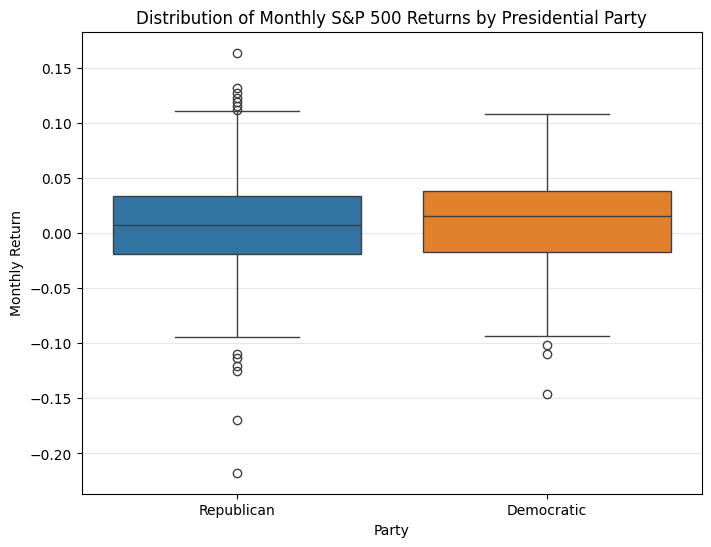

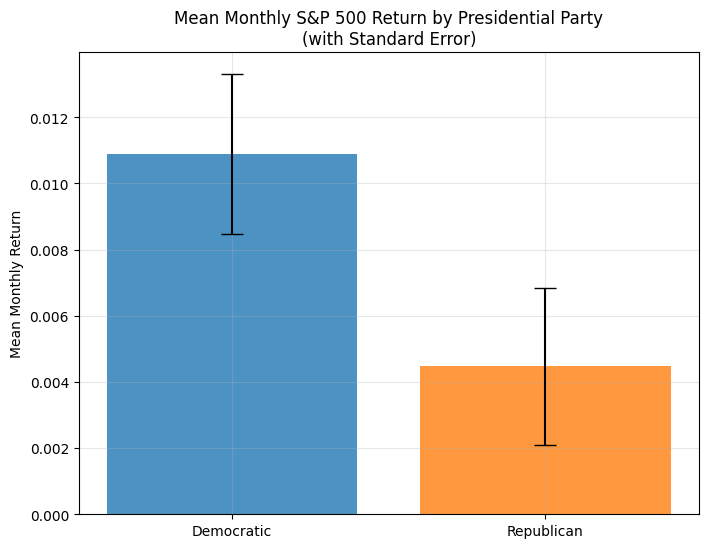

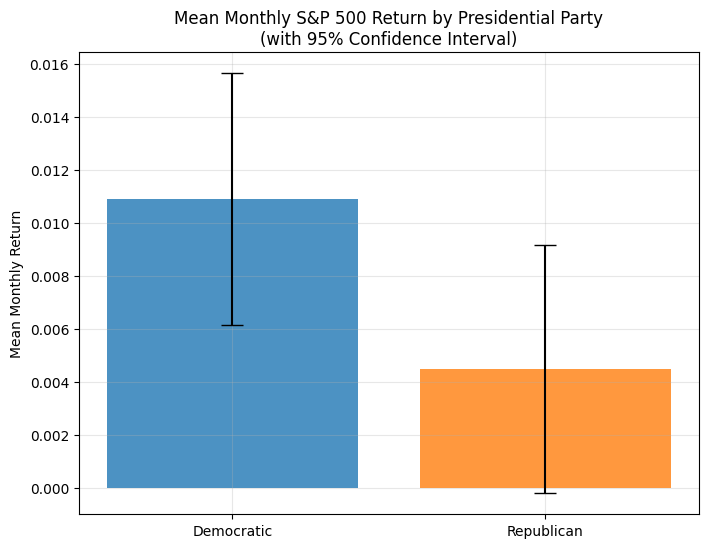

In [73]:
# Visualization: Boxplot of Monthly Returns by Party
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=sp500_with_returns.dropna(subset=['Monthly_Return', 'Party']),
    x='Party', y='Monthly_Return', palette=['#1f77b4', '#ff7f0e']
)
plt.title('Distribution of Monthly S&P 500 Returns by Presidential Party')
plt.ylabel('Monthly Return')
plt.xlabel('Party')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Visualization: Bar Chart of Mean Monthly Return with Error Bars
means = [dem_returns.mean(), rep_returns.mean()]
std_errs = [dem_returns.sem(), rep_returns.sem()]
parties = ['Democratic', 'Republican']
colors = ['#1f77b4', '#ff7f0e']

plt.figure(figsize=(8, 6))
plt.bar(parties, means, yerr=std_errs, color=colors, capsize=8, alpha=0.8)
plt.ylabel('Mean Monthly Return')
plt.title('Mean Monthly S&P 500 Return by Presidential Party\n(with Standard Error)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

means = [dem_returns.mean(), rep_returns.mean()]
conf_ints = [
    st.t.interval(0.95, len(dem_returns)-1, loc=dem_returns.mean(), scale=dem_returns.sem()),
    st.t.interval(0.95, len(rep_returns)-1, loc=rep_returns.mean(), scale=rep_returns.sem())
]
# Calculate error as distance from mean to upper/lower bound
errors = [
    means[0] - conf_ints[0][0],  # Democratic
    means[1] - conf_ints[1][0]   # Republican
]

plt.figure(figsize=(8, 6))
plt.bar(parties, means, yerr=errors, color=colors, capsize=8, alpha=0.8)
plt.ylabel('Mean Monthly Return')
plt.title('Mean Monthly S&P 500 Return by Presidential Party\n(with 95% Confidence Interval)')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## 7. Comparing Political Party Influence Pre and Post 2000s

In this section, we will analyze whether the influence of political parties on S&P 500 returns was stronger in the pre-2000s era compared to the post-2000s era. We will categorize the data into two time periods and perform statistical analysis to compare the returns.

In [74]:
# e.g. if you originally computed returns on sp500_with_returns:
returns = sp500_with_returns[['Date','Monthly_Return']]

# merge into the presidents df
sp500_with_presidents = sp500_with_presidents.merge(returns, on='Date', how='left')

# now drop any rows where we’re missing party or returns
df = sp500_with_presidents.dropna(subset=['Monthly_Return','Party'])

# group exactly as before
mean_returns = df.groupby(['Era','Party'])['Monthly_Return'].mean().unstack()
std_errs    = df.groupby(['Era','Party'])['Monthly_Return'].sem().unstack()

print(mean_returns)
print(std_errs)


Party       Democratic  Republican
Era                               
Post-2000s    0.010034    0.000501
Pre-2000s     0.011894    0.007054
Party       Democratic  Republican
Era                               
Post-2000s    0.003386    0.003719
Pre-2000s     0.003448    0.003092


In [75]:
# Perform t-tests for each era
results = {}
for era in sp500_with_presidents['Era'].unique():
    dem_returns = sp500_with_presidents[(sp500_with_presidents['Party'] == 'Democratic') & 
                                         (sp500_with_presidents['Era'] == era)]['Monthly_Return'].dropna()
    rep_returns = sp500_with_presidents[(sp500_with_presidents['Party'] == 'Republican') & 
                                         (sp500_with_presidents['Era'] == era)]['Monthly_Return'].dropna()
    
    t_stat, p_value = stats.ttest_ind(dem_returns, rep_returns, equal_var=False, nan_policy='omit')
    results[era] = {
        'Democratic Mean': dem_returns.mean(),
        'Republican Mean': rep_returns.mean(),
        't-statistic': t_stat,
        'p-value': p_value
    }

# Display results
for era, res in results.items():
    print(f"\n{era} Results:")
    print(f"Democratic Mean: {res['Democratic Mean']:.4f}")
    print(f"Republican Mean: {res['Republican Mean']:.4f}")
    print(f"t-statistic: {res['t-statistic']:.4f}")
    print(f"p-value: {res['p-value']:.4f}")


Pre-2000s Results:
Democratic Mean: 0.0119
Republican Mean: 0.0071
t-statistic: 1.0451
p-value: 0.2968

Post-2000s Results:
Democratic Mean: 0.0100
Republican Mean: 0.0005
t-statistic: 1.8954
p-value: 0.0590


### 8. Visualization of Mean Returns by Era and Party

Now, let's visualize the mean returns for each party in both eras to better understand the differences.

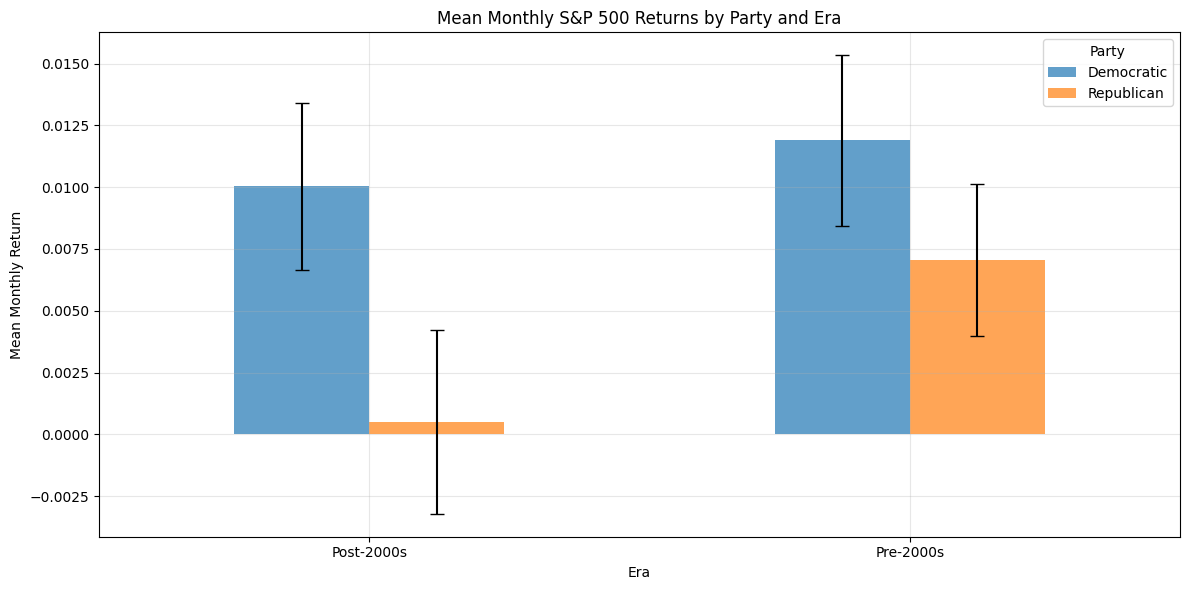

In [76]:
# Bar Chart of Mean Returns by Era and Party
mean_returns.plot(kind='bar', yerr=std_errs, capsize=5, alpha=0.7)
plt.title('Mean Monthly S&P 500 Returns by Party and Era')
plt.ylabel('Mean Monthly Return')
plt.xlabel('Era')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Party')
plt.tight_layout()
plt.show()